In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [173]:
plt.style.use('bmh')

In [310]:
# load Rrs - IOP dataset
ds = xr.load_dataset('./data/psc_rrs_iop.nc')
# load inversion results
ds_inv = xr.load_dataset('./data/psc_rrs_inversion.nc')

In [311]:
ds_inv['iop'] = ['a', 'bb']

In [312]:
ds_inv['r_error'] = ds_inv.std_error/ds_inv.conc

In [313]:
ds_inv['conc'] = ds_inv.conc.where(ds_inv.r_error<3)
ds_inv['iops'] = ds_inv.iops.where(ds_inv.r_error<3)

In [314]:
# ds_inv['conc'] = ds_inv.conc.where(id_nan)
#ds_inv['iops'] = ds_inv.iops.where(id_nan)

In [343]:
def plot_validation(xy, x_label=None, y_label=None, ncol=2, **kwargs):
    nrow = int(np.ceil(len(xy)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=kwargs.get('figsize'))
    axs = axs.flat
    
    for i in xy:
        x = i.get('x').values
        y = i.get('y').values
        # total number of observation
        n = len(x)
        # mask nans
        mask = ~np.any([np.isnan(y), y==0], axis=0)
        ax = next(axs)
        # determine min and max of axes
        ax_min, ax_max = [np.min(x[mask])*.2, np.max(x[mask])*2.5]
        ay_min, ay_max = [np.min(y[mask])*.2, np.max(y[mask])*2.5]
        # log-transform x and y
        x_log = np.log10(np.reshape(x[mask], (-1,1)))
        y_log = np.log10(np.reshape(y[mask], (-1,1)))
        # calculate regression stats
        lm = LinearRegression().fit(x_log,y_log)
        # regression line
        x_log_range = np.logspace(np.log10(ax_min), np.log10(ax_max))
        lm_line = np.power(10, lm.coef_[0][0]*np.log10(x_log_range)+lm.intercept_[0])
        # color
#         col = np.log(bbdm_550)[mask]
        
        # plot scatter
        ax.plot(x_log_range,  lm_line, color='red', linewidth=1, linestyle='--')
        #ax.scatter(x[mask], y[mask], c=col[mask], alpha=.7, edgecolor='black')
        ax.scatter(x[mask], y[mask], alpha=.7, edgecolor='black')
        ax.plot(np.linspace(ax_min, ax_max),
                np.linspace(ax_min, ax_max), 'k', linewidth=.7)
        # plot stats
        stat_str = 'MAE: {0:.3g}\nR2: {1:.3g}\nSlope: {2:.3g}\nIntercept: {3:.3g}\nf: {4:.3g}'\
                .format(mean_absolute_error(x[mask],y[mask]),
                        r2_score(x_log,y_log),
                        lm.coef_[0][0],
                        lm.intercept_[0],
                        len(x[mask])/len(x))
        ax.annotate(stat_str, xy=(.05, .95), xycoords='axes fraction', ha='left', va='top')
        ax.set_title(i.get('name'))
        # set axis labels and scale
        ax.set_xlabel('observed ({})'.format(i.get('units')))
        ax.set_ylabel('predicted ({})'.format(i.get('units')))
        ax.set_xscale('log')
        ax.set_yscale('log')
        # set axis limits
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ay_min, ay_max])  
   
    fig.subplots_adjust(right=0.8)
    fig.tight_layout()
    
    return None

### Chlorophyll retrievals

In [344]:
# pico
pico = {
    'x': ds.conc.sel(comp='pico'),
    'y': ds_inv.conc.sel(comp='pico'),
    'units': '$mg\ m^{-3}$',
    'name': 'pico'
}
# nano
nano = {
    'x': ds.conc.sel(comp='nano'),
    'y': ds_inv.conc.sel(comp='nano'),
    'units': '$mg\ m^{-3}$',
    'name': 'nano'
}
# micro
micro = {
    'x': ds.conc.sel(comp='micro'),
    'y': ds_inv.conc.sel(comp='micro'),
    'units': '$mg\ m^{-3}$',
    'name': 'micro'
}
# total chlorophyll
chl = {
    'x': ds.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1),
    'y': ds_inv.conc.sel(comp=['pico', 'nano', 'micro']).sum(axis=1),
    'units': '$mg\ m^{-3}$',
    'name': 'chl'
}

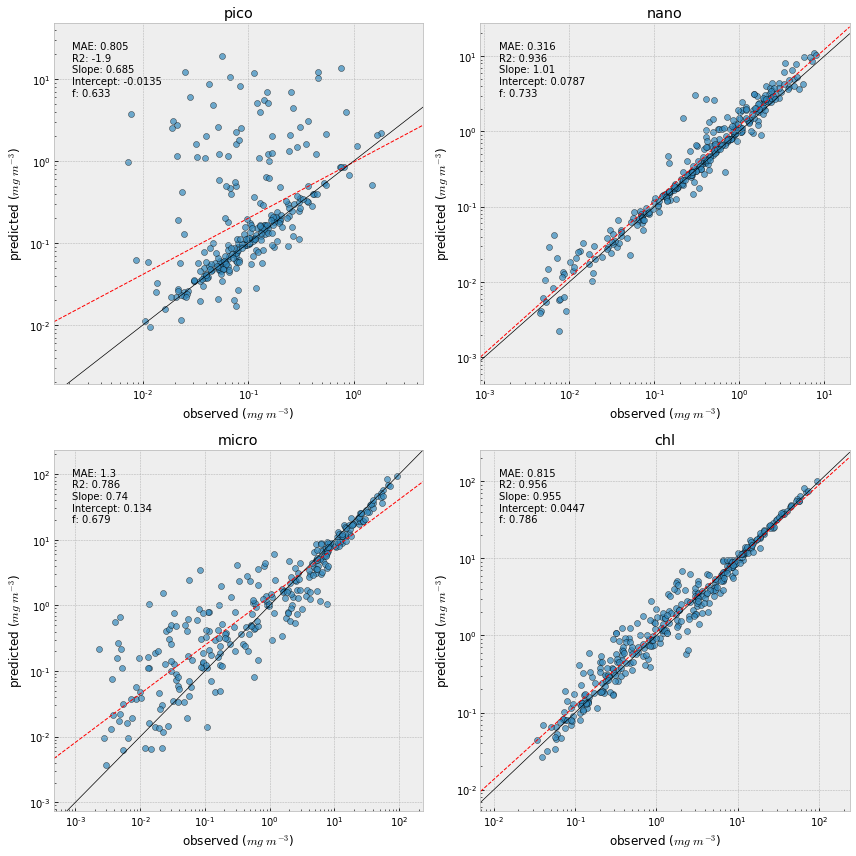

In [345]:
plot_validation([pico, nano, micro, chl], figsize=(12,12))

### IOP retrievals

Absorption by detrital matter and CDOM...

In [358]:
# detrital matter absorption
adm_440 = {
    'x': ds.iops.sel(comp='dm', iop='a', wavelength=440),
    'y': ds_inv.iops.sel(comp='dm', iop='a', wavelength=440),
    'units': '$m^{-1}$',
    'name': 'detrital matter $a(440)$'
}
# detrital matter bb
bbdm_550 = {
    'x': ds.iops.sel(comp='dm', iop='bb', wavelength=550),
    'y': ds_inv.iops.sel(comp='dm', iop='bb', wavelength=550),
    'units': '$m^{-1}$',
    'name': 'detrital matter $b_b(550)$'
}
# cdom
cdom_440 = {
    'x': ds.iops.sel(comp='cdom', iop='a', wavelength=440),
    'y': ds_inv.iops.sel(comp='cdom', iop='a', wavelength=440),
    'units': '$m^{-1}$',
    'name': 'cdom $a(440)$'
}

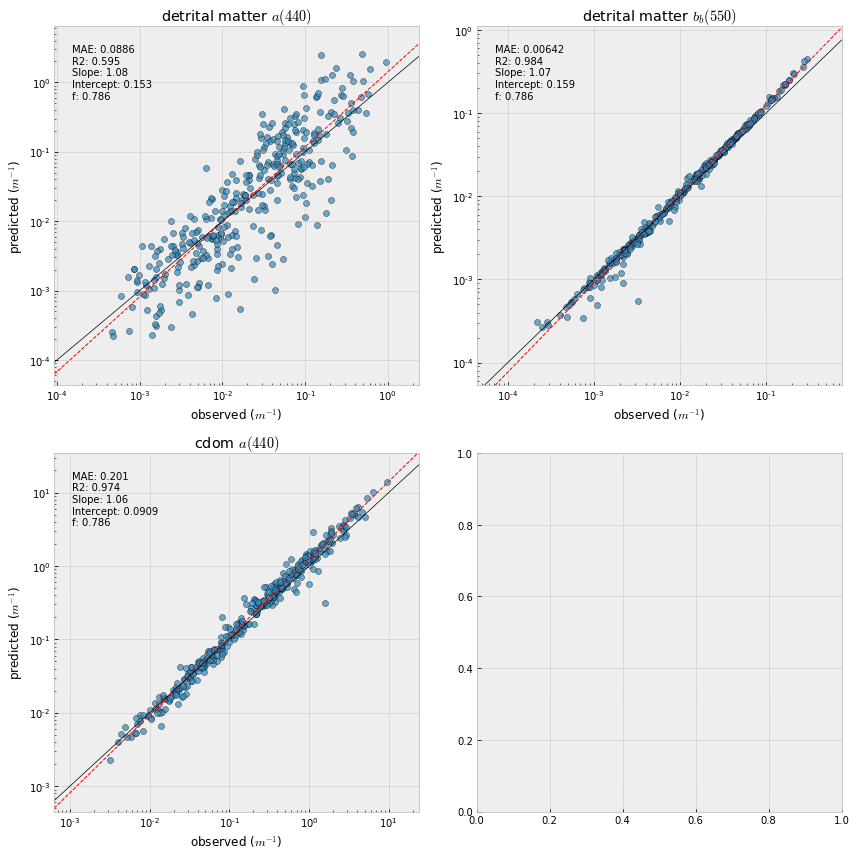

In [359]:
plot_validation([adm_440, bbdm_550, cdom_440], figsize=(12,12))

Total absorption (at 440 nm) and backscatter (at 550 nm)...

In [340]:
# total absorption @ 440 nm
a_440 = {
    'x': ds.iops.sel(wavelength=440, iop='a').sum(axis=1),
    'y': ds_inv.iops.sel(wavelength=440, iop='a').sum(axis=1),
    'units': '$m^{-1}$',
    'name': 'total absorption (440 nm)'
}
# total backscatter @ 550 nm
bb_550 = {
    'x': ds.iops.sel(wavelength=550, iop='bb').sum(axis=1),
    'y': ds_inv.iops.sel(wavelength=550, iop='bb').sum(axis=1),
    'units': '$m^{-1}$',
    'name': 'total backscatter (550 nm)'
}

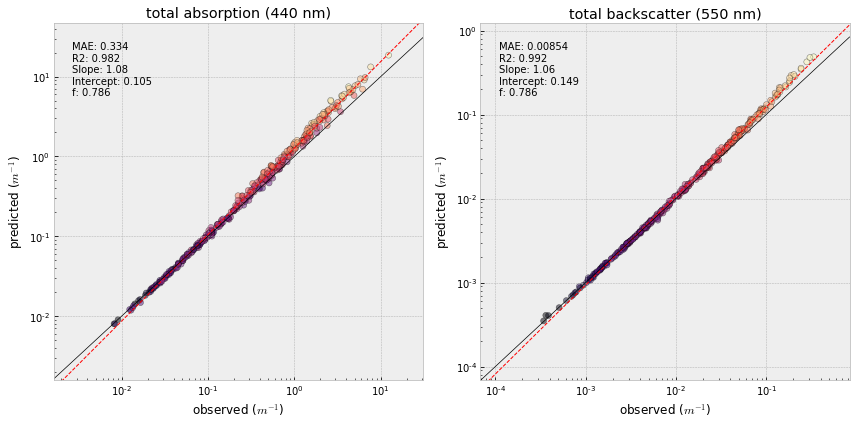

In [341]:
plot_validation([a_440, bb_550], figsize=(12,6))

### $R_{rs}$ validation

In [302]:
#rrs @ 440
rrs_440 = {
    'x': ds.rrs.sel(wavelength=440),
    'y': ds_inv.rrs.sel(wavelength=440),
    'units': '$sr^{-1}$',
    'name': '$R_{rs}(440)$'
}
# rrs @ 550
rrs_550 = {
    'x': ds.rrs.sel(wavelength=550),
    'y': ds_inv.rrs.sel(wavelength=550),
    'units': '$sr^{-1}$',
    'name': '$R_{rs}(550)$'
}

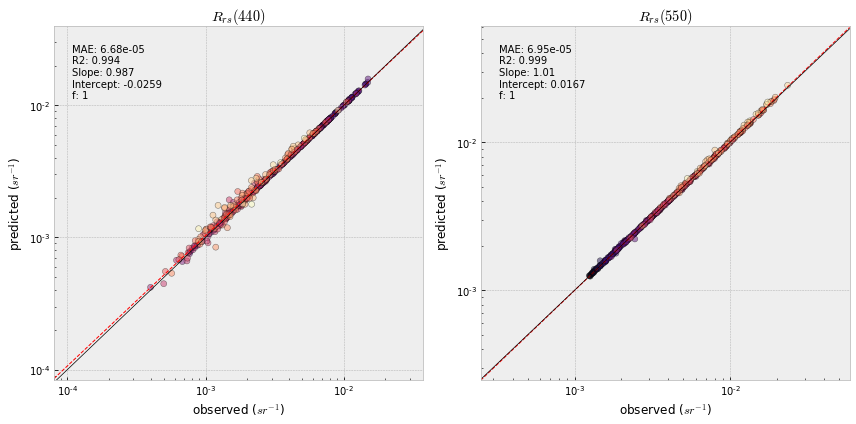

In [342]:
plot_validation([rrs_440, rrs_550], figsize=(12,6))